# Aplicação de uma Rede Neural profunda para o desafio KDD 2009

O objetivo desse notebook é propor um modelo preditivo para o desafio da KDD 2009. Nesse desafio a tarefa é, com base em um banco de dados com 50.000 contas bancárias predizer a proabilidade de um cliente: 

- Cancelar sua conta (churn), 
- Usar novos produtos e serviços (appetency) 
- Comprar upgrades ou adicionais a sua conta quando apresentado (up-selling)

**De forma especifica, os objetivos são:**

- Analisar os bancos de dados disponibilizados
- Estruturar um modelo em rede neural
- Treinar esse modelo utilizando o framework de *tratamento / desenvolvimento / teste*


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python.framework import ops
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)
from sklearn.metrics import roc_auc_score

## 1.0 - Banco de dados

A versão small do banco de dados disponibilizado para esse desafio consiste em 260 informações sobre 50.000 contas bancárias. 
As primeiras 190 variáveis são numéricas (representam quantidade: ex. salário), enquanto as 40 restante são categoricas (representam qualidade ex. genero).

In [3]:
dataset = pd.read_table('datasets/orange_small_train.data', sep='\t', header=0)

labels_appetency = pd.read_table('datasets/orange_small_train_appetency.labels', sep='\t', header=-1)
labels_upselling = pd.read_table('datasets/orange_small_train_upselling.labels', sep='\t', header=-1)
labels_churn = pd.read_table('datasets/orange_small_train_churn.labels', sep='\t', header=-1)

In [4]:
def redimencionaLabels(label):
    """
    Redefine as dimensões das variáveis de resposta (label). Substitui -1 por 0 e converte do formato pandas.Dataframe 
    para numpy.array
    
    Arguments:
    label -- pandas.DataFrame da variável resposta
        
    Returns:
    label como matriz nas dimensões 0 e 1.
    """
        
    label[label==-1] = 0
    return label.as_matrix()

labels_appetency = redimencionaLabels(labels_appetency)
labels_upselling = redimencionaLabels(labels_upselling)
labels_churn = redimencionaLabels(labels_churn)

Sobre as variáveis de resposta, observa-se que é uma baixa porcentagem de clientes que apresentam os eventos, a saber, cancelam suas contas, compram novos produtos e compram upgrades.

In [14]:
print("Porcentagem de observações com appentency=1 %f" % (float(len(labels_appetency[labels_appetency==1]))/50000))
print("Porcentagem de observações com upselling=1 %f" % (float(len(labels_upselling[labels_upselling==1]))/50000))
print("Porcentagem de observações com churn=1 %f" % (float(len(labels_churn[labels_churn==1]))/50000))

Porcentagem de observações com appentency=1 0.017800
Porcentagem de observações com upselling=1 0.073640
Porcentagem de observações com churn=1 0.073440


In [15]:
dataset.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var11,Var12,Var13,Var14,Var15,Var16,Var17,Var18,Var19,Var20,Var21,Var22,Var23,Var24,Var25,Var26,Var27,Var28,Var29,Var30,Var31,Var32,Var33,Var34,Var35,Var36,Var37,Var38,Var39,Var40,Var41,Var42,Var43,Var44,Var45,Var46,Var47,Var48,Var49,Var50,Var51,Var52,Var53,Var54,Var55,Var56,Var57,Var58,Var59,Var60,Var61,Var62,Var63,Var64,Var65,Var66,Var67,Var68,Var69,Var70,Var71,Var72,Var73,Var74,Var75,Var76,Var77,Var78,Var79,Var80,Var81,Var82,Var83,Var84,Var85,Var86,Var87,Var88,Var89,Var90,Var91,Var92,Var93,Var94,Var95,Var96,Var97,Var98,Var99,Var100,Var101,Var102,Var103,Var104,Var105,Var106,Var107,Var108,Var109,Var110,Var111,Var112,Var113,Var114,Var115,Var116,Var117,Var118,Var119,Var120,Var121,Var122,Var123,Var124,Var125,Var126,Var127,Var128,Var129,Var130,Var131,Var132,Var133,Var134,Var135,Var136,Var137,Var138,Var139,Var140,Var141,Var142,Var143,Var144,Var145,Var146,Var147,Var148,Var149,Var150,Var151,Var152,Var153,Var154,Var155,Var156,Var157,Var158,Var159,Var160,Var161,Var162,Var163,Var164,Var165,Var166,Var167,Var168,Var169,Var170,Var171,Var172,Var173,Var174,Var175,Var176,Var177,Var178,Var179,Var180,Var181,Var182,Var183,Var184,Var185,Var186,Var187,Var188,Var189,Var190,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,Var202,Var203,Var204,Var205,Var206,Var207,Var208,Var209,Var210,Var211,Var212,Var213,Var214,Var215,Var216,Var217,Var218,Var219,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,1526.0,7.0,NaN,NaN,NaN,NaN,NaN,184.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,464.0,580.0,NaN,14.0,128.0,NaN,NaN,166.56,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,3570.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.076907,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36,35.0,NaN,1350864.0,NaN,0.0,NaN,NaN,7333.11,NaN,5.0,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.0,NaN,NaN,168.0,117625.60,NaN,NaN,NaN,NaN,NaN,1175.0,NaN,NaN,NaN,6.0,NaN,720.0,8.0,NaN,NaN,NaN,NaN,NaN,0.0,1212385.0,69134.0,NaN,NaN,NaN,NaN,NaN,185.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,NaN,397579.0,NaN,NaN,NaN,1812252.0,NaN,NaN,NaN,NaN,NaN,NaN,142.0,NaN,NaN,38418.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,462.0,NaN,NaN,bZkvyxLkBI,RO12,NaN,taul,1K8T,lK27,ka_ns41,nQUveAzAF7,NaN,NaN,dXGu,9_Y1,FbIm,VpdQ,haYg,me75fM6ugJ,kIsH,NaN,uKAI,L84s,XfqtO3UdzaXh_,NaN,NaN,NaN,XTbPUYD,sH5Z,cJvF,FzaX,1YVfGrO,oslk,fXVEsaq,jySVZNlOJy,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,525.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,168.0,210.0,NaN,2.0,24.0,NaN,NaN,353.52,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,4764966.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.408032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,26,0.0,NaN,2872928.0,NaN,3.0,NaN,NaN,151098.90,NaN,25.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58158.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.0,NaN,NaN,40.0,-356411.60,NaN,NaN,NaN,NaN,NaN,590.0,NaN,NaN,NaN,72.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,8.0,4136430.0,357038.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,NaN,278334.0,NaN,NaN,NaN,10439160.0,NaN,NaN,NaN,NaN,NaN,NaN,32.0,NaN,NaN,238572.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CEat0G8rTN,RO12,NaN,taul,1K8T,2Ix5,qEdASpP,y2LIM01bE1,NaN,NaN,lg1t,9_Y1,k13i,sJzTlal,zm5i,me75fM6ugJ,kIsH,NaN,uKAI,L84s,NhsEn4L,NaN,NaN,NaN,kZJyVg2,NaN,NaN,FzaX,0AJo2f2,oslk,2Kb5FSF,LM8l689qOp,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,5236.0,7.0,NaN,NaN,NaN,NaN,NaN,904.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1212.0,1515.0,NaN,26.0,816.0,NaN,NaN,220.08,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,5883894.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.599658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130,518.0,NaN,1675

Uma análise preliminiar das 5 primeiras linhas desse banco de dados indica que:
- Como se trata de um banco de informações pessoais de clientes, a identificação das variáveis, bem como os valores apresentados foram codificados para não expor informações. Assim, o modelo preditivo não pode utilizar um conhecimento teórico sobre o banco de dados para escolher variáveis.
- Há muitas informações não disponiveis (NaN) que necessitam de um tratamento. Algoritmos de machine learning tendem a apresentar erros na presença desses dados.

De forma geral, há duas opções no tratamento de valores não disponíveis:
- Remover observações que apresentam alguma variável não disponível;
- Imputar um valor para NaN, ou seja, substituir valores não disponíveis por zero, pela média da variável, ou alguma outra métrica.

In [16]:
print("Número de observações em dataset com Nan: %d " % len(dataset[dataset.isnull().any(axis=1)]))

Número de observações em dataset com Nan: 50000 


Todas as observações no banco de dados possui algum dado não disponível. Assim, faz se necessário algum tratamento a essas variáveis. Para variáveis numéricas imputarei a média da coluna para substituir esses valores não disponiveis. A média em si é um valor representativo para a coluna. Outro ponto importante no que tange o tratamento dos dados quantitavivos, é a normalização das variáveis. Essas variáveis foram normalizadas com média 0 e desvio padrão unitário. Essa técnica evita que grandes variabilidades em determinadas variáveis não atrapalhe o processo de minimização do erro.

In [5]:
def removeVarsQtdeNaN(dataframe, limiar=0.3):
    """
    Mantem no dataframe apenas variáveis que possuem mais de 70% das observações diferentes de NaN
    
    Arguments:
    dataframe -- dataframe de análise
        
    Returns:
    lista de variáveis com mais de 70% das observações diferentes de NaN
    """
    varsNA = dataframe.isnull().sum() < int(50000*limiar)
    return list(varsNA.index[varsNA==True])
    
variaveis_numericas = list(dataset)[:190]

dataset_vars_numericas = dataset[variaveis_numericas]

# Excluir colunas em que todas as observações são NaN
dataset_vars_numericas = dataset_vars_numericas.dropna(axis=1, how='all')

# Manter colunas em que mais da metade das observações são diferentes de NaN
dataset_vars_numericas = dataset_vars_numericas[removeVarsQtdeNaN(dataset_vars_numericas)]

# Substitui NaN pela média da coluna
dataset_vars_numericas = dataset_vars_numericas.fillna(dataset_vars_numericas.mean())

In [6]:
dataset_vars_numericas1 = (dataset_vars_numericas - dataset_vars_numericas.mean())/(dataset_vars_numericas.std()+0.00001)

Para variáveis categóricas NaN pode representar um conjunto de categorias não considerada no momento de coleta das informações. Por exemplo, uma variável categorica de genero que considere apenas masculino ou feminino em suas opções desconsidera um conjunto extenso de generos que um indivíduo pode se enquadrar. NaN nesse caso representa tudo exceto masculino ou feminino e assim pode representar um genero em específico.

In [7]:
variaveis_categoricas = list(dataset)[190:]

"""
Cria variáveis dummies para variáveis categoricas

Exemplo: suponha que a v1 assuma as categorias A e B. O código abaixo cria duas novas variáveis v1_A e v1_B
em que v1_A assume 1 quando a observação for igual a A e 0 caso o contrário

"""

dataset_vars_categoricas = dataset[variaveis_categoricas]

# Excluir colunas em que todas as observações são NaN
dataset_vars_categoricas = dataset_vars_categoricas.dropna(axis=1, how='all')

# Manter colunas em que mais da metade das observações são diferentes de NaN
dataset_vars_categoricas = dataset_vars_categoricas[removeVarsQtdeNaN(dataset_vars_categoricas)]

In [9]:
drop_vars = ['Var192', 'Var198', 'Var199', 'Var202', 'Var216', 'Var217', 'Var220', 'Var222']
dataset_vars_categoricas = dataset_vars_categoricas.drop(drop_vars, axis=1)

dataset_vars_categoricas = pd.get_dummies(dataset_vars_categoricas, columns=list(dataset_vars_categoricas), dummy_na=True)

In [10]:
# Libera memória
del dataset_vars_numericas
del dataset

In [11]:
# Unir os dois datasets
dataset = pd.concat([dataset_vars_numericas1, dataset_vars_categoricas], axis=1)

In [12]:
dataset.head()

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,Var44,Var57,Var65,Var73,Var74,Var76,Var78,Var81,Var83,Var85,Var109,Var112,Var113,Var119,Var123,Var125,Var126,Var132,Var133,Var134,Var140,Var143,Var144,Var149,Var153,Var160,Var163,Var173,Var181,Var193_2Knk1KF,Var193_2wnefc9ISdLjfQoAYBI,Var193_5QKIjwyXr4MCZTEp7uAkS8PtBLcn,Var193_8kO9LslBGNXoLvWEuN6tPuN59TdYxfL9Sm6oU,Var193_9U2tunPAje3TwfLLUQxzM3dC1ghn,Var193_AERks4l,Var193_B2T7ZTgOX7xpBPBD28SLvVWgBkc13Sm0a3tk2,Var193_BrRu5UxtiQY9TTJ8ABKpfS,Var193_ByQdnLRlFnny2k4AJzG,Var193_DH86UFkz9LK6My0ezUgZx96oI,Var193_Fveq5yuDUj6drSMiZO3mXe,Var193_GpoBynXzkxADI7bZBtqvX2IPV5t7o2QCPE,Var193_IlTgyyFksv4BT,Var193_J71wxZB6Jn0CR82XoyV,Var193_JXVE,Var193_KjAW4rq3iyvu8XwKkyQ2_svIATjM3B5,Var193_LrdVolaSGUfkVeWC,Var193_LrdZy8QqgUfkVShG,Var193_MJdP52puUMWhmExsNdlkGDbNTFln2Eg,Var193_ND3t9Yro9U,Var193_NMCEYavk0YOlqn2jHeEDjP0xsdXeAZGnZDN0NOfV,Var193_NRCqczK,Var193_OpDzzQJ,Var193_PomAbFU,Var193_QG5U1Qs9mF3805lxYz2cGPnrm,Var193_RO12,Var193_SrUWsbENd7prk,Var193_T9RM7fDFhhZjjBFsk5zptG,Var193_TW8dXluYzKpktZjuY8kSPBaZa,Var193_X1rJx42ksaRn3qcM,Var193_X2uI6IsGev,Var193__7J0OGNN8s6gFzbM,Var193_bYmQ4nc,Var193_e6CkoqApVR,Var193_eSGpMwS8zSGgq_trOpckZ5,Var193_g62hiBSaKg,Var193_gGvYE2F8JHtPlbzkGbl,Var193_hnq7pOcHWLojUTXc7HQutLwmffdy,Var193_iKEouAWeUBYR3fQ5tZmt_bDPIn6qT7tIGHs8L,Var193_msph93375qXRfw6hcMceRRIDdmHq8wn,Var193_onTuEhrJJQy_H3IHkZku5AFczhYGqxJ890,Var193_qqimvRzsp8ZZdKRPgzLg68joSn_k,Var193_rEUOq2QD1qfkRr6qpua,Var193_snf9xe6PBwBZ8lKzhEz,Var193_ues7INAmyjdS1vDd0YL9jU,Var193_vuPfq6YcbX,Var193_w9ygS99Qp_,Var193_wvnt2iBhAPeGqIKaFUxJc6ca3IYp,Var193_yaM_UXtlxCFW5NHTcftwou7BmXcP9VITdHAto,Var193_z3s4Ji522ZB1FauqOOqbkl,Var193_zPhCMhkz9XiOF7LgT9VfJZ3yI,Var193_nan,Var195_ArtjQZ8ftr3NB,Var195_ArtjQZQO1r9fC,Var195_ArtjQZmIvr94p,Var195_BNjsq81k1tWAYigY,Var195_CiJDdr4TQ0rGERIS,Var195_CiJsoa4TQ0rGHlMp,Var195_CuXi4je,Var195_F1JQrEL,Var195_I9xt3GBDKUbd8,Var195_I9xt3GDRhUK7p,Var195_I9xt3GMcxUnBZ,Var195_I9xt3Gi01UK7p,Var195_LfvqpCtLOY,Var195_TnJpfvsJgF,Var195_V10_0kx3ZF2we,Var195_XMIgoIlPqx,Var195_ZZBPiZh,Var195_b_3Q,Var195_bsZtYxFjzA,Var195_ev6I,Var195_hiMqnEM7VgIk4JUu,Var195_lSbpiq1,Var195_taul,Var195_nan,Var196_1K8T,Var196_JA1C,Var196_mKeq,Var196_z3mO,Var196_nan,Var197_0LaQ,Var197_0WHw,Var197_0Xwj,Var197_0Y9G,Var197_0YIT,Var197_0aHy,Var197_0kpG,Var197_0zDT,Var197_12fX,Var197_19FS,Var197_1QqW,Var197_1TqK,Var197_2D6V,Var197_2Ix5,Var197_2wit,Var197_3PdN,Var197_42Cy,Var197_487l,Var197_4JaS,Var197_4fje,Var197_5B99,Var197_5IqI,Var197_5tHj,Var197_6syR,Var197_72yt,Var197_7ALb,Var197_7M9D,Var197_7gSz,Var197_7wJ6,Var197_80HR,Var197_8PU_,Var197_8qEx,Var197_94m7,Var197_99vr,Var197_AHgj,Var197_AHrt,Var197_AKN1,Var197_AkfA,Var197_AnrR,Var197_AuRO,Var197_Bxva,Var197_CNAE,Var197_CRc0,Var197_ChAX,Var197_Cnh8,Var197_D68y,Var197_D_RP,Var197_DmpM,Var197_E4OP,Var197_EJC9,Var197_EPHy,Var197_EWYi,Var197_EbEb,Var197_Epqo,Var197_EzKK,Var197_F9g8,Var197_FAjL,Var197_FPxv,Var197_FWqf,Var197_FgS1,Var197_Fq5T,Var197_G6s_,Var197_GYbZ,Var197_GtOw,Var197_Guv5,Var197_HR69,Var197_I0gp,Var197_IGdn,Var197_IIni,Var197_Irwt,Var197_IvdZ,Var197_IxTr,Var197_JD_f,Var197_JLbT,Var197_KJW5,Var197_KXDt,Var197_KqYs,Var197_L80O,Var197_LFM_,Var197_LLPZ,Var197_LXO4,Var197_LZs_,Var197_L_LK,Var197_LloI,Var197_MeKL,Var197_MoUp,Var197_MrXh,Var197_NF63,Var197_NHzE,Var197_NSDI,Var197_NbV4,Var197_OF8b,Var197_ONrL,Var197_OTVu,Var197_OY2L,Var197_P9et,Var197_PGNs,Var197_PJLW,Var197_PShj,Var197_PbOJ,Var197_QG1d,Var197_QQSE,Var197_R4_H,Var197_R5iW,Var197_Rn7z,Var197_RnYz,Var197_RsSg,Var197_S5pa,Var197_SzjZ,Var197_TIPl,Var197_TLkP,Var197_Ti2P,Var197_Tw4q,Var197_TyGl,Var197_URNM,Var197_USOt,Var197_Uk76,Var197_UkfA,Var197_Ulfj,Var197_UpNf,Var197_VPX5,Var197_W5sH,Var197_WkTj,Var197_Wmd1,Var197_Wz5C,Var197_X94c,Var197_X9_k,Var197_Xa_z,Var197_Y2P0,Var197_YFAj,...,Var204_rzbc,Var204_t_4G,Var204_vYXv,Var204_vm5R,Var204_vzJD,Var204_wGwL,Var204_xQ2A,Var204_xSqs,Var204_yrDU,Var204_z5Ry,Var204_zfpA,Var204_nan,Var205_09_Q,Var205_VpdQ,Var205_sJzTlal,Var205_nan,Var206_409L,Var206_43pnToF,Var206_6

In [13]:
# Transforma dataset em um formato numpy matriz
dataset = dataset.as_matrix()

A motivação para a construção de qualquer modelo preditivo é prever novos eventos. No contexto da instituição bancária, por exemplo, esta procura um modelo que, dada as informações de novos clientes, seja possível prever se este cancelará ou não sua conta bancária. Assim, além de esperar um bom desempenho preditivo em dados disponíveis para o treinamento do algoritmo, espera-se um bom desempenho em um conjunto de dados que o algoritmo nunca teve acesso.

Nesse contexto, uma prática largamente difundida em procedimentos preditivos é separar, aleatoriamente, os dados disponíveis em 3 conjuntos:

- Treinamento: Trata-se do conjunto em que a rede neural será treinada. Espera-se um bom desempenho preditivo nesse conjunto, dado que os algoritmos utilizados na rede neural partem da premissa de ajustar os pesos de modo a minimizar os erros;
- Desenvolvimento: Conjunto de dados que será utilizado para avaliar o melhor conjunto de hiperparâmetros para a rede neural;
- Teste: Conjunto que apresenta o desempenho final do modelo, avaliando a qualidade do modelo junto a um banco de dados nunca visto pela rede.

A proporção de divisão das 50.000 observações será 60% para o conjunto treinamento, 20% para desenvolvimento e 20% teste.

In [14]:
porc_train, porc_dev = 0.6, 0.2 # Define as porcentagens de observações em treinamento e desenvolvimento

np.random.seed(1) # Para reprodução
m = dataset.shape[0]
indices = np.arange(m)
np.random.shuffle(indices)

train_indices = indices[:int(porc_train*m)]
dev_indices = indices[int(porc_train*m):int((porc_train + porc_dev)*m)]
test_indices = indices[int((porc_train + porc_dev)*m):]

# Conjuntos treinamento
train_dataset, train_appetency = dataset[train_indices, ], labels_appetency[train_indices, ] 
train_upselling, train_churn = labels_upselling[train_indices,], labels_churn[train_indices, ]

# Conjuntos desenvolvimento
dev_dataset, dev_appetency = dataset[dev_indices, ], labels_appetency[dev_indices, ] 
dev_upselling, dev_churn = labels_upselling[dev_indices,], labels_churn[dev_indices, ]

# Conjuntos de teste
test_dataset, test_appetency = dataset[test_indices, ], labels_appetency[test_indices, ] 
test_upselling, test_churn = labels_upselling[test_indices,], labels_churn[test_indices, ]

In [15]:
del dataset

## 2 - Modelo de Rede neural construido no TensorFlow

[TensorFlow](https://www.tensorflow.org/) é uma biblioteca de código aberta desenvolvida pela Google, para construção de modelos em machine learning. Essa biblioteca possui API que facilita consideravelmente os processos de construção de uma rede neural, trazendo mais velocidade ao processamento de dados. [tf.placeholder()](https://www.tensorflow.org/api_docs/python/tf/placeholder) permite que o modelo receba diferentes conjuntos de dados com diferentes parâmetros.

In [16]:
def criar_placeholders(n_x, n_y):
    """
    Cria placeholder para uma sessão no TensorFlow
        
    Arguments:
    n_x -- scalar, número de variável para input
    n_y -- scalar, número de classes da variável resposta
        
    Returns:
    X -- placeholder para input, com formato [None, n_x] e dtype "float"
    Y -- placeholder para labels, com formato [None, n_y] e dtype "float"
    """
    
    X = tf.placeholder(shape=(None, n_x), dtype=tf.float32)
    Y = tf.placeholder(shape=(None, n_y), dtype=tf.float32)
        
    return X, Y

foward propagation é o método em redes neurais que representa os inputs sendo transformados pelos pesos de cada nó em cada layer da rede neural, bem como pelas funções de ativação. A ideia é transformar os inputs pela interação dos pesos e funções de ativação para gerar o output final. O método abaixo gera esse método, bem como a possibilidade de gerar n layers ocultas.

In [17]:
def forward_propagation(x, n_y, neurons):
    """
    Realiza a forward_propagation com base nos pesos treinados, número de layers e nós por layer
        
    Arguments:
    x -- input em tensorflow
    n_y -- scalar, número de classes da variável resposta
    neurons -- lista com o número de nós para cada layer oculta
        
    Returns:
    X -- placeholder para input, com formato [None, n_x] e dtype "float"
    Y -- placeholder para labels, com formato [None, n_y] e dtype "float"
    """
    
    layers = {}
    
    for i, n_oculta in enumerate(neurons):
        if i==0:
            layers['layer_'+str(i)] = tf.layers.dense(inputs=x, units=n_oculta, 
                                                      kernel_initializer=tf.contrib.layers.xavier_initializer(seed = 0))
        else:
            layers['layer_'+str(i)] = tf.layers.dense(inputs=layers['layer_'+str(i-1)], units=n_oculta, 
                                                     kernel_initializer=tf.contrib.layers.xavier_initializer(seed = 0))
        
   
    out_layer = tf.layers.dense(inputs=layers['layer_'+str(i)], units=n_y, activation=tf.nn.sigmoid)

    return out_layer

O objetivo da rede neural é minimizar uma função custo, para variáveis binárias. [tf.nn.sigmoid_cross_entropy_with_logits](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) garante o cálculo dessa função.

In [18]:
def computa_custo(ZL, Y):
    """
    Computa o custo
    
    Arguments:
    ZL -- output da forward propagation
    Y -- placeholder do vector label (Y)
    
    Returns:
    custo - Tensor da função custo
    """
    
    custo = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = ZL, labels = Y))
        
    return custo

O modelo utiliza a técnica de mini-batch gradiente descendente. Essa técnica divide randomicamente o banco de dados de treinamento em pequenas porções que são usadas para calcular o erro do modelo e atualizar os coeficientes. Além de computacionalmente mais eficiente, esse método evita que os processos de minimização da função custo fiquem presos em um mínimo local.

In [19]:
def random_mini_batches(X, Y, tamanho_mini_batch = 128, seed = 0):
    """
    Cria uma lista de minibatches aleatórios para  (X, Y)
    
    Arguments:
    X -- input data
    Y -- label 
    tamanho_mini_batch - tamanho do minibatch
    seed -- para manter os mesmos resultados dos processos aleatórios
    
    Returns:
    mini_batches -- lista de minibatches
    """
    
    m = X.shape[0]
    mini_batches = []
    np.random.seed(seed)
    
    # Passo 1: Embaralha (X, Y)
    permutacao = list(np.random.permutation(m))
    embaralha_X = X[permutacao,:]
    embaralha_Y = Y[permutacao,:]

    # Passo 2: Particiona os bacthes
    num_minibatches_completos = m//tamanho_mini_batch
    
    for k in range(0, num_minibatches_completos):
        mini_batch_X = embaralha_X[k * tamanho_mini_batch : k * tamanho_mini_batch + tamanho_mini_batch,:]
        mini_batch_Y = embaralha_Y[k * tamanho_mini_batch : k * tamanho_mini_batch + tamanho_mini_batch,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Para o caso do último batch ainda sobrar observações
    if m % tamanho_mini_batch != 0:
        mini_batch_X = embaralha_X[num_minibatches_completos * tamanho_mini_batch : m,:]
        mini_batch_Y = embaralha_Y[num_minibatches_completos * tamanho_mini_batch : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

Definido os processos acima, implementa-se o método de cálculo do modelo.

In [20]:
def model(X_train, Y_train, neurons, X_dev, Y_dev, X_test=None, Y_test=None, learning_rate = 0.009,
          num_epochs = 100, tamanho_minibatch = 64, print_custo = True):
    """
    Implementa uma Rede Neural
    
    Arguments:
    X_train -- Conjunto de treinamento
    Y_train -- Variável resposta (label) do conjunto treinamento
    X_test -- Conjunto de desenvolvimento
    Y_test -- Variável de resposta do conjunto desenvolvimento
    learning_rate -- taxa de aprendizado para otimização
    num_epochs -- número de epochs para o for loop
    tamanho_minibatch -- tamanho do minibatch
    print_custo -- True para printar custo a cada 100 epochs
    
    Returns:
    train_auc -- AUC do conjunto de treinamento
    test_accuracy -- AUC do conjunto de teste
    
    """
    
    ops.reset_default_graph()                         
    tf.set_random_seed(1234)                            
    seed = 3                                          
    (m, n_x) = X_train.shape             
    n_y = Y_train.shape[1]                            
    custos = []                                        
    
    # Cria placeholders
    X, Y = criar_placeholders(n_x, n_y)
        
    # Forward propagation
    ZL = forward_propagation(X, n_y=n_y, neurons=neurons)
    
    
    # Função de custo
    custo = computa_custo(ZL, Y)
    
    # Backpropagation: Usar AdamOptimizer para minimizar o custo
    otimizador = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(custo)
        
    # Inicia todas as variáveis globalmente
    init = tf.global_variables_initializer()
     
    # Inicia a sessão
    with tf.Session() as sess:
        
        sess.run(init)
        #sess.run(tf.local_variables_initializer())
        a = sess.run(tf.round(ZL), {X: X_train})
        print("Inicio soma predict zl %s" % (np.sum(a)))
        # Loop de treinamento
        for epoch in range(num_epochs):

            custo_minibatch = 0.
            num_minibatches = int(m / tamanho_minibatch)
            seed = seed + 1 # alterar o padrão de aleatoriedade dos minibatchs
            minibatches = random_mini_batches(X_train, Y_train, tamanho_minibatch, seed)

            for minibatch in minibatches:
                
                (minibatch_X, minibatch_Y) = minibatch
                _ , custo_temp = sess.run([otimizador, custo], feed_dict={X: minibatch_X, Y: minibatch_Y})
                                
                custo_minibatch += custo_temp / num_minibatches
                                
           
            if print_custo == True and epoch % 5 == 0:
                print ("Custo depois da epoch %i: %f" % (epoch, custo_minibatch))
            if print_custo == True and epoch % 1 == 0:
                custos.append(custo_minibatch)
        
        if print_custo == True:
        
            # plot os custos
            plt.plot(np.squeeze(custos))
            plt.ylabel('Custo')
            plt.xlabel('Epochs')
            plt.title("Learning rate =" + str(learning_rate))
            plt.show()

        # Calcule AUC para avaliar os modelos
                
        #predict_train, Y_train = sess.run([tf.round(ZL), Y], feed_dict={X: X_train, Y: Y_train})
        predict_train = sess.run(tf.round(ZL), feed_dict={X: X_train})
        
        print("sum predict %s" % (np.sum(predict_train)))
        
        train_auc = roc_auc_score(Y_train, predict_train)
        
        predict_dev = sess.run(tf.round(ZL), feed_dict={X: X_dev})
        dev_auc = roc_auc_score(Y_dev, predict_dev)
        
        if X_test is not None:
            predict_test = sess.run(tf.round(ZL), feed_dict={X: X_test})
            test_auc = roc_auc_score(Y_test, predict_test)
            print("test_auc " + str(test_auc))
        
        return train_auc, dev_auc

A curva ROC apresenta a relação entre Precision e Recall. Espera-se que quanto maior a área abaixo da curva AUC melhor seja o modelo preditivo.

Nos códigos abaixo será executado 16 modelos, variando o número de layers ocultas bem com o número de nós em cada layer respectivamente. Além das layers, será testado 4 valores diferentes de learning_rate.

In [51]:
nodes = [[100, 80, 60, 40, 10], [80, 60, 40, 10], [60, 40, 10], [40, 10]]
learning_rates = [0.1, 0.5, 0.01, 0.001]

In [54]:
print("appetency")

for node in nodes:
    print("\n\n\nNode " + str(node))
    for learning_rate in learning_rates:
        print("\n\nLearning rate %f" %(learning_rate))
        
        train_auc, dev_auc = model(X_train=train_dataset, Y_train = train_appetency, 
                                   neurons=node,   
                                   X_dev=dev_dataset, Y_dev=dev_appetency, 
                                   num_epochs = 100, 
                                   learning_rate =learning_rate,
                                  print_custo = False)
        
        print("train_auc: %f" %(train_auc))
        print("dev_auc: %f" %(dev_auc))

appetency



Node [100, 80, 60, 40, 10]


Learning rate 0.100000
Inicio soma predict zl 10589.0
sum predict 24.0
train_auc: 0.499593
dev_auc: 0.502128


Learning rate 0.500000
Inicio soma predict zl 10589.0
sum predict 29637.0
train_auc: 0.501178
dev_auc: 0.495253


Learning rate 0.010000
Inicio soma predict zl 10589.0
sum predict 411.0
train_auc: 0.498008
dev_auc: 0.499167


Learning rate 0.001000
Inicio soma predict zl 10589.0
sum predict 0.0
train_auc: 0.500000
dev_auc: 0.500000



Node [80, 60, 40, 10]


Learning rate 0.100000
Inicio soma predict zl 5043.0
sum predict 5808.0
train_auc: 0.479166
dev_auc: 0.471318


Learning rate 0.500000
Inicio soma predict zl 5043.0
sum predict 29604.0
train_auc: 0.501737
dev_auc: 0.500986


Learning rate 0.010000
Inicio soma predict zl 5043.0
sum predict 1.0
train_auc: 0.499983
dev_auc: 0.500000


Learning rate 0.001000
Inicio soma predict zl 5043.0
sum predict 0.0
train_auc: 0.500000
dev_auc: 0.500000



Node [60, 40, 10]


Learning rate 0.100000

O melhor valor de dev_auc para o modelo preditivo para appetency foi 0,508 para o caso de 3 layers ocultas com, respectivamente, 60, 40 e 10 nós e learning rate de 0,01.

Inicio soma predict zl 7122.0
Custo depois da epoch 0: 0.695446
Custo depois da epoch 5: 0.694670
Custo depois da epoch 10: 0.694670
Custo depois da epoch 15: 0.694670
Custo depois da epoch 20: 0.694670
Custo depois da epoch 25: 0.694670
Custo depois da epoch 30: 0.701703
Custo depois da epoch 35: 0.703141
Custo depois da epoch 40: 0.703155
Custo depois da epoch 45: 0.703141
Custo depois da epoch 50: 0.703155
Custo depois da epoch 55: 0.703148
Custo depois da epoch 60: 0.703141
Custo depois da epoch 65: 0.703155
Custo depois da epoch 70: 0.703148
Custo depois da epoch 75: 0.703148
Custo depois da epoch 80: 0.703141
Custo depois da epoch 85: 0.703148
Custo depois da epoch 90: 0.703141
Custo depois da epoch 95: 0.703148
Custo depois da epoch 100: 0.703141
Custo depois da epoch 105: 0.703141
Custo depois da epoch 110: 0.703141
Custo depois da epoch 115: 0.703169
Custo depois da epoch 120: 0.703155
Custo depois da epoch 125: 0.703148
Custo depois da epoch 130: 0.703155
Custo depois da epoc

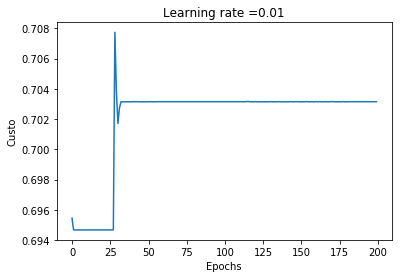

sum predict 416.0
test_auc 0.5054764427232424


In [60]:
train_auc, dev_auc = model(X_train=train_dataset, Y_train = train_appetency, 
                                   neurons=[60, 40, 10],   
                                   X_dev=dev_dataset, Y_dev=dev_appetency,
                                   X_test=test_dataset, Y_test=test_appetency,
                                   num_epochs = 200, 
                                   learning_rate =0.01,
                                  print_custo = True)

In [61]:
print("upselling")

for node in nodes:
    print("\n\n\nNode " + str(node))
    for learning_rate in learning_rates:
        print("\n\nLearning rate %f" %(learning_rate))
        
        train_auc, dev_auc = model(X_train=train_dataset, Y_train = train_upselling, 
                                   neurons=node,   
                                   X_dev=dev_dataset, Y_dev=dev_upselling, 
                                   num_epochs = 100, 
                                   learning_rate =learning_rate,
                                  print_custo = False)
        
        print("train_auc: %f" %(train_auc))
        print("dev_auc: %f" %(dev_auc))

upselling



Node [100, 80, 60, 40, 10]


Learning rate 0.100000
Inicio soma predict zl 10589.0
sum predict 15.0
train_auc: 0.499972
dev_auc: 0.500552


Learning rate 0.500000
Inicio soma predict zl 10589.0
sum predict 29500.0
train_auc: 0.498335
dev_auc: 0.496604


Learning rate 0.010000
Inicio soma predict zl 10589.0
sum predict 124.0
train_auc: 0.499222
dev_auc: 0.500262


Learning rate 0.001000
Inicio soma predict zl 10589.0
sum predict 0.0
train_auc: 0.500000
dev_auc: 0.499946



Node [80, 60, 40, 10]


Learning rate 0.100000
Inicio soma predict zl 5043.0
sum predict 5391.0
train_auc: 0.519546
dev_auc: 0.530434


Learning rate 0.500000
Inicio soma predict zl 5043.0
sum predict 29628.0
train_auc: 0.502091
dev_auc: 0.496866


Learning rate 0.010000
Inicio soma predict zl 5043.0
sum predict 0.0
train_auc: 0.500000
dev_auc: 0.500000


Learning rate 0.001000
Inicio soma predict zl 5043.0
sum predict 1.0
train_auc: 0.500224
dev_auc: 0.500000



Node [60, 40, 10]


Learning rate 0.100000

O melhor valor de dev_auc para o modelo preditivo para upselling foi 0,5304 para o caso de 4 layers ocultas com, respectivamente, 80, 60, 40 e 10 nós e learning rate de 0,1.

Inicio soma predict zl 5043.0
Custo depois da epoch 0: 0.696117
Custo depois da epoch 5: 0.790258
Custo depois da epoch 10: 0.790224
Custo depois da epoch 15: 0.790238
Custo depois da epoch 20: 0.790268
Custo depois da epoch 25: 0.790231
Custo depois da epoch 30: 0.790252
Custo depois da epoch 35: 0.790215
Custo depois da epoch 40: 0.790217
Custo depois da epoch 45: 0.790218
Custo depois da epoch 50: 0.790272
Custo depois da epoch 55: 0.790204
Custo depois da epoch 60: 0.790247
Custo depois da epoch 65: 0.790217
Custo depois da epoch 70: 0.790240
Custo depois da epoch 75: 0.790224
Custo depois da epoch 80: 0.790236
Custo depois da epoch 85: 0.790231
Custo depois da epoch 90: 0.790238
Custo depois da epoch 95: 0.790222
Custo depois da epoch 100: 0.790222
Custo depois da epoch 105: 0.790252
Custo depois da epoch 110: 0.790227
Custo depois da epoch 115: 0.790229
Custo depois da epoch 120: 0.790206
Custo depois da epoch 125: 0.790210
Custo depois da epoch 130: 0.790220
Custo depois da epoc

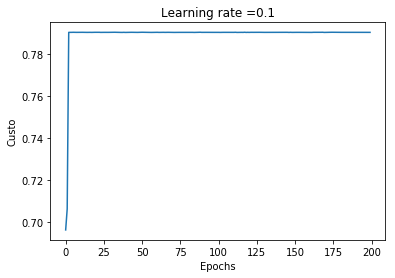

sum predict 5391.0
test_auc 0.5207197011932561


In [62]:
train_auc, dev_auc = model(X_train=train_dataset, Y_train = train_upselling, 
                                   neurons=[80, 60, 40, 10],   
                                   X_dev=dev_dataset, Y_dev=dev_upselling,
                                   X_test=test_dataset, Y_test=test_upselling,
                                   num_epochs = 200, 
                                   learning_rate =0.1,
                                  print_custo = True)

In [63]:
print("churn")

for node in nodes:
    print("\n\n\nNode " + str(node))
    for learning_rate in learning_rates:
        print("\n\nLearning rate %f" %(learning_rate))
        
        train_auc, dev_auc = model(X_train=train_dataset, Y_train = train_churn, 
                                   neurons=node,   
                                   X_dev=dev_dataset, Y_dev=dev_churn, 
                                   num_epochs = 100, 
                                   learning_rate =learning_rate,
                                  print_custo = False)
        
        print("train_auc: %f" %(train_auc))
        print("dev_auc: %f" %(dev_auc))

churn



Node [100, 80, 60, 40, 10]


Learning rate 0.100000
Inicio soma predict zl 10589.0
sum predict 141.0
train_auc: 0.499901
dev_auc: 0.500674


Learning rate 0.500000
Inicio soma predict zl 10589.0
sum predict 29637.0
train_auc: 0.499949
dev_auc: 0.500578


Learning rate 0.010000
Inicio soma predict zl 10589.0
sum predict 291.0
train_auc: 0.505492
dev_auc: 0.504120


Learning rate 0.001000
Inicio soma predict zl 10589.0
sum predict 5.0
train_auc: 0.500154
dev_auc: 0.499892



Node [80, 60, 40, 10]


Learning rate 0.100000
Inicio soma predict zl 5043.0
sum predict 5808.0
train_auc: 0.491556
dev_auc: 0.494952


Learning rate 0.500000
Inicio soma predict zl 5043.0
sum predict 29604.0
train_auc: 0.498836
dev_auc: 0.499785


Learning rate 0.010000
Inicio soma predict zl 5043.0
sum predict 5.0
train_auc: 0.499910
dev_auc: 0.500000


Learning rate 0.001000
Inicio soma predict zl 5043.0
sum predict 0.0
train_auc: 0.500000
dev_auc: 0.500000



Node [60, 40, 10]


Learning rate 0.100000
In

O melhor valor de dev_auc para o modelo preditivo para churn foi 0,5025 para o caso de 3 layers ocultas com, respectivamente, 60, 40 e 10 nós e learning rate de 0,1.

Inicio soma predict zl 24476.0
Custo depois da epoch 0: 0.699950
Custo depois da epoch 5: 0.698603
Custo depois da epoch 10: 0.698603
Custo depois da epoch 15: 0.698603
Custo depois da epoch 20: 0.698610
Custo depois da epoch 25: 0.698610
Custo depois da epoch 30: 0.698624
Custo depois da epoch 35: 0.698610
Custo depois da epoch 40: 0.698603
Custo depois da epoch 45: 0.698610
Custo depois da epoch 50: 0.698617
Custo depois da epoch 55: 0.698603
Custo depois da epoch 60: 0.698610
Custo depois da epoch 65: 0.698603
Custo depois da epoch 70: 0.698603
Custo depois da epoch 75: 0.698603
Custo depois da epoch 80: 0.698603
Custo depois da epoch 85: 0.698603
Custo depois da epoch 90: 0.698610
Custo depois da epoch 95: 0.698610
Custo depois da epoch 100: 0.698603
Custo depois da epoch 105: 0.698603
Custo depois da epoch 110: 0.698603
Custo depois da epoch 115: 0.698610
Custo depois da epoch 120: 0.698603
Custo depois da epoch 125: 0.698603
Custo depois da epoch 130: 0.698603
Custo depois da epo

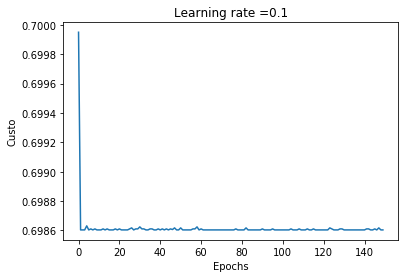

sum predict 221.0
test_auc 0.50072355384


In [21]:
train_auc, dev_auc = model(X_train=train_dataset, Y_train = train_churn, 
                                   neurons=[60, 40, 10],   
                                   X_dev=dev_dataset, Y_dev=dev_churn,
                                   X_test=test_dataset, Y_test=test_churn,
                                   num_epochs = 150, 
                                   learning_rate =0.1,
                                  print_custo = True)

### Conclusão final
Os valores de AUC para os três modelos, considerando o conjunto de teste são:
- appetency: 0.5054
- upselling: 0.5208
- churn: 0.5007

Para futuros desenvolvimentos e melhorias é importante considerar:
- Utilizar API do tensorflow para calculo da rede neural
- Utilizar processos paralelos para trabalhar com todo o banco de dados;
- Implementar novos métodos que apresentem um desempenho melhor para o caso de variável reposta (label) desbalanceada.